Get `pandas` and `numpy` for feature engineering and calculations, `importlib` for reloading external code and force plots inline.

In [25]:
import pandas as pd
import numpy  as np

import importlib

from pyearth import Earth
from pyearth import export

#import urllib

%matplotlib inline

Use next cell when running in an external environment to pick up the configuration from `git`.

In [26]:
#!wget -N https://gitlab.com/dzwietering/corona/-/raw/master/experiment/params/pr.py

Import parameters and force reload.

In [27]:
import pr
importlib.reload(pr)

<module 'pr' from '/home/zwieteri/git/corona/experiment/params/pr.py'>

We use the daily spreadsheet from OWID containing new cases and deaths per country per day.

In [28]:
#urllib.request.urlretrieve(pr.casurl+pr.casfil, pr.casfil)

url = pr.casurl + pr.casfil
!wget -N $url

--2022-08-08 16:18:49--  https://covid.ourworldindata.org/data/owid-covid-data.csv
Resolving covid.ourworldindata.org (covid.ourworldindata.org)... 188.114.97.0, 188.114.96.0, 2a06:98c1:3120::c, ...
Connecting to covid.ourworldindata.org (covid.ourworldindata.org)|188.114.97.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘owid-covid-data.csv’

owid-covid-data.csv     [         <=>        ]  56.17M  11.4MB/s    in 4.9s    

Last-modified header missing -- time-stamps turned off.
2022-08-08 16:18:54 (11.5 MB/s) - ‘owid-covid-data.csv’ saved [58904046]



We read our dataframe directly from the downloaded Excel file and have a look at the first 10 lines for format. Data for Namibia caused missing values because the `geoId` is __NA__, so we disable interpretation of missing values.

In [29]:
df = pd.read_csv(
    pr.casfil,
    keep_default_na = False,
    na_values       = '',
    parse_dates     = pr.datrdc,
    dayfirst        = True,
)

# show the last rows as columns in reverse order
(
    df
    .tail(5)
    .transpose()
    .iloc[:, ::-1]
)

207072  \
iso_code                                                 ZWE   
continent                                             Africa   
location                                            Zimbabwe   
date                                     2022-08-07 00:00:00   
total_cases                                         256447.0   
...                                                      ...   
human_development_index                                0.571   
excess_mortality_cumulative_absolute                     NaN   
excess_mortality_cumulative                              NaN   
excess_mortality                                         NaN   
excess_mortality_cumulative_per_million                  NaN   

                                                      207071  \
iso_code                                                 ZWE   
continent                                             Africa   
location                                            Zimbabwe   
date                                     2022-08-06 00:00:00   
total_cases                                         256444.0   
...                                                      ...   
human_development_index                                0.571   
excess_mortality_cumulative_absolute                     NaN   
excess_mortality_cumulative                              NaN   
excess_mortality                                         NaN   
excess_mortality_cumulative_per_million                  NaN   

                                                      207070  \
iso_code                                                 ZWE   
continent                                             Africa   
location                                            Zimbabwe   
date                                     2022-08-05 00:00:00   
total_cases                                         256444.0   
...                                                      ...   
human_development_index                                0.571   
excess_mortality_cumulative_absolute                     NaN   
excess_mortality_cumulative                              NaN   
excess_mortality                                         NaN   
excess_mortality_cumulative_per_million                  NaN   

                                                      207069  \
iso_code                                                 ZWE   
continent                                             Africa   
location                                            Zimbabwe   
date                                     2022-08-04 00:00:00   
total_cases                                         256444.0   
...                                                      ...   
human_development_index                                0.571   
excess_mortality_cumulative_absolute                     NaN   
excess_mortality_cumulative                              NaN   
excess_mortality                                         NaN   
excess_mortality_cumulative_per_million                  NaN   

                                                      207068  
iso_code                                                 ZWE  
continent                                             Africa  
location                                            Zimbabwe  
date                                     2022-08-03 00:00:00  
total_cases                                         256423.0  
...                                                      ...  
human_development_index                                0.571  
excess_mortality_cumulative_absolute                     NaN  
excess_mortality_cumulative                              NaN  
excess_mortality                                         NaN  
excess_mortality_cumulative_per_million                  NaN  

[67 rows x 5 columns]

Last check of our source dataframe.

In [30]:
df = (
    df
    .dropna(
        subset=[
            pr.dimcol,
        ]
    )
)

lastdate = (
    df
    [pr.datcol]
    .max()
    - pd.Timedelta(pr.datmrg)
)
(
    df
    .count()
)

iso_code                                   207073
continent                                  195102
location                                   207073
date                                       207073
total_cases                                198700
                                            ...  
human_development_index                    165887
excess_mortality_cumulative_absolute         7021
excess_mortality_cumulative                  7021
excess_mortality                             7039
excess_mortality_cumulative_per_million      7021
Length: 67, dtype: int64

We pivot to a country by column format.

In [31]:
df_dim = (
    df
    .pivot_table(
        index   = pr.datcol,
        columns = pr.dimcol,
        values  = pr.cascol,
        aggfunc = 'sum',
    )
    .fillna(0)
)
(
    df_dim
)

new_cases                                                          \
iso_code         ABW    AFG    AGO   AIA    ALB    AND     ARE      ARG  ARM   
date                                                                           
2020-01-01       0.0    0.0    0.0   0.0    0.0    0.0     0.0      0.0  0.0   
2020-01-02       0.0    0.0    0.0   0.0    0.0    0.0     0.0      0.0  0.0   
2020-01-03       0.0    0.0    0.0   0.0    0.0    0.0     0.0      0.0  0.0   
2020-01-04       0.0    0.0    0.0   0.0    0.0    0.0     0.0      0.0  0.0   
2020-01-05       0.0    0.0    0.0   0.0    0.0    0.0     0.0      0.0  0.0   
...              ...    ...    ...   ...    ...    ...     ...      ...  ...   
2022-08-03      69.0  273.0    0.0  40.0  979.0  285.0  1009.0      0.0  0.0   
2022-08-04       0.0  304.0    0.0   0.0  776.0    0.0  1084.0      0.0  0.0   
2022-08-05       0.0  340.0  335.0   0.0  808.0    0.0   998.0      0.0  0.0   
2022-08-06       0.0   72.0    0.0   0.0  831.0    0.0   994.0      0.0  0.0   
2022-08-07       0.0  333.0    0.0   0.0  538.0    0.0   945.0  42227.0  0.0   

                  ... new_deaths                                               
iso_code     ATG  ...        VGB  VIR  VNM  VUT  WLF  WSM  YEM  ZAF  ZMB  ZWE  
date              ...                                                          
2020-01-01   0.0  ...        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2020-01-02   0.0  ...        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2020-01-03   0.0  ...        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2020-01-04   0.0  ...        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2020-01-05   0.0  ...        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...          ...  ...        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
2022-08-03   0.0  ...        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
2022-08-04   0.0  ...        0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  2.0  
2022-08-05   0.0  ...        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2022-08-06   0.0  ...        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
2022-08-07  14.0  ...        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  3.0  

[950 rows x 488 columns]

For predictions later on we need extra rows in our dataframe. One of the ways to do that is reindexing with a larger range, so we add to the current range and check our latest date.

In [32]:
new_index = pd.date_range(
    (
        df_dim
        .index
        .min()
    ),
    (
        df_dim
        .index
        .max() 
        + pd.Timedelta(pr.futext)
    ),
)
df_dim = (
    df_dim
    .reindex(
        new_index,
    )
)
(
    df_dim
)

new_cases                                               ...  \
iso_code         ABW  AFG  AGO  AIA  ALB  AND  ARE  ARG  ARM  ATG  ...   
2020-01-01       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2020-01-02       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2020-01-03       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2020-01-04       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2020-01-05       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
...              ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2023-08-03       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2023-08-04       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2023-08-05       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2023-08-06       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2023-08-07       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   

           new_deaths                                               
iso_code          VGB  VIR  VNM  VUT  WLF  WSM  YEM  ZAF  ZMB  ZWE  
2020-01-01        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2020-01-02        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2020-01-03        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2020-01-04        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2020-01-05        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...               ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
2023-08-03        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2023-08-04        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2023-08-05        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2023-08-06        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2023-08-07        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[1315 rows x 488 columns]

We need numerical data as inputs for a model, so we add a column representing the date as days since the start of the index.

In [33]:
df_dim['daynum'] = (
    (
        (
            df_dim
            .index
        )
        -
        (
            df_dim
            .index
            .min()
        )
    )
    .days
)
(
    df_dim
    ['daynum']
    .describe()
)

count    1315.000000
mean      657.000000
std       379.752112
min         0.000000
25%       328.500000
50%       657.000000
75%       985.500000
max      1314.000000
Name: daynum, dtype: float64

The typical progress of an outbreak seems to fit a Gumbel distribution, where the cumulative distribution is a double negative exponent: `exp(-exp(-x))`. The measures are averaged by week to smooth out reporting lags.

In [34]:
def gumpdf(x, beta, mu):
    """Return PDF value according to Gumbel"""
    expon = - ((x - mu) / beta)
    return(np.exp(expon) * np.exp(- (np.exp(expon))) / beta)

def gumcdf(x, beta, mu):
    """Return CDF value according to Gumbel"""
    expon = - ((x - mu) / beta)
    return(np.exp(- (np.exp(expon))))

Append date to plot title.

In [35]:
pr.pldate = ' - '+lastdate.strftime('%Y-%m-%d')

Run for all dimensions.

Running multiple wave analysis for Netherlands with population 17501696
Minimum number of cases is 2
Wave 01 beta 18.490 mu  99 fit 0.631 peak 2020-04-09 from 2020-02-27 to 2020-09-02 size 48825
Wave 02 beta  3.071 mu  90 fit 0.650 peak 2020-03-31 from 2020-03-25 to 2020-04-19 size 1375
Wave 03 beta  5.212 mu 104 fit 0.782 peak 2020-04-14 from 2020-04-04 to 2020-05-16 size 2288
Wave 04 beta  5.508 mu 212 fit 0.842 peak 2020-07-31 from 2020-07-20 to 2020-09-05 size 3786
Wave 05 beta  5.242 mu 221 fit 0.838 peak 2020-08-09 from 2020-07-29 to 2020-09-15 size 5295
Wave 06 beta  5.777 mu 230 fit 0.722 peak 2020-08-18 from 2020-08-06 to 2020-09-29 size 7595
Wave 07 beta  7.683 mu 248 fit 0.783 peak 2020-09-05 from 2020-08-19 to 2020-10-31 size 11188
Wave 08 beta 12.287 mu 271 fit 0.815 peak 2020-09-28 from 2020-08-29 to 2021-01-13 size 73365
Wave 09 beta  8.096 mu 282 fit 0.906 peak 2020-10-09 from 2020-09-20 to 2020-12-18 size 43649
Wave 10 beta  7.252 mu 290 fit 0.890 peak 2020-10-17 from 

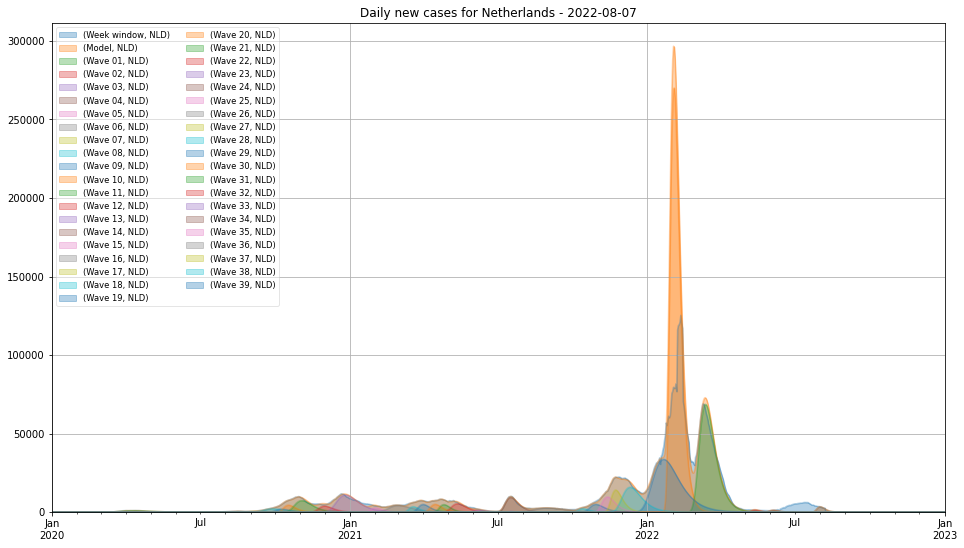

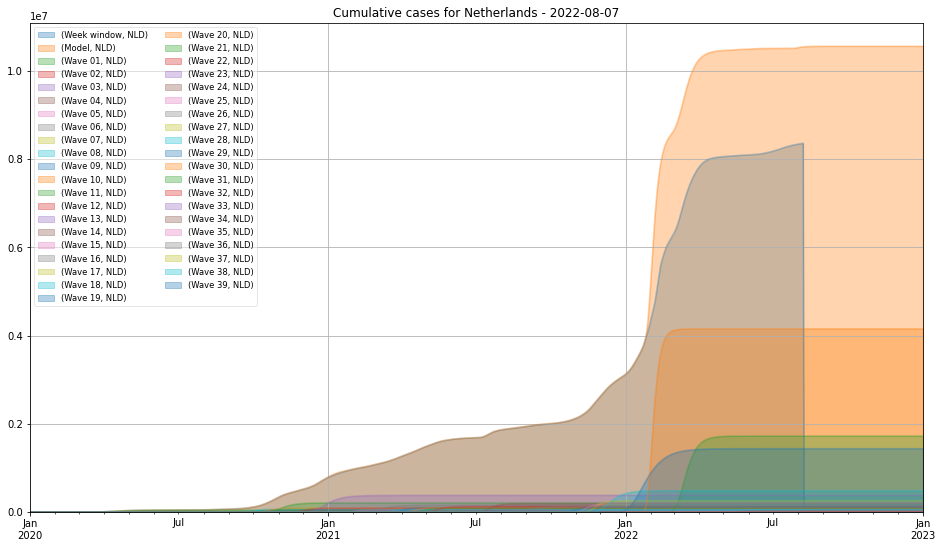

In [36]:
if not pr.dimlist:
    pr.dimlist = (
        df
        [pr.dimcol]
        .unique()
    )
    pr.dimlist.sort()

for pr.dim in pr.dimlist:

    wave = pr.firstwav

    # Initialize predicted measure, create smoothed measure and remaining cases
    df_dim[(pr.pmeasure, pr.dim)] = 0
    df_dim[(pr.smeasure, pr.dim)] = (
        df_dim
        [pr.measure]
        [pr.dim]
        .loc[:lastdate]
        .rolling(pr.sdays)
        .mean()
    )
    df_dim[(pr.rmeasure, pr.dim)] = (
        df_dim
        [pr.smeasure]
        [pr.dim]
    )

    # Always plot smoothed and predicted measures, adding waves when found
    plotlist = [
        (pr.smeasure, pr.dim),
        (pr.pmeasure, pr.dim),
    ]

    # Get full name and population from the original dataset
    dimnam = (
        df
        [
            df
            [pr.dimcol] 
            == pr.dim
        ]
        [pr.namcol]
        .iloc[-1]
    )
    dimpop = (
        df
        [
            df
            [pr.dimcol]
            == pr.dim
        ]
        [pr.popcol]
        .iloc[-1]
    )

    # We use a minimum number of cases, but at least 2
    mincases = max(
        dimpop / pr.popcases,
        pr.mincases,
    )

    print(
        'Running multiple wave analysis for {} with population {:1.0f}'
        .format(
            dimnam,
            dimpop,
        )
    )
    print(
        'Minimum number of cases is {:1.0f}'
        .format(
            mincases,
        )
    )

    while True:
        # Create potential wave
        curwave = (
            pr.wmeasure 
            + str(
                wave 
                + (10 ** pr.wavenum)
            )
            [-pr.wavenum:]
        )
        df_dim[(curwave, pr.dim)] = 0

        # Create a dataframe for projections
        df_proj = pd.DataFrame(
            {
                'daynum': 
                    (
                        df_dim
                        ['daynum']
                    ),
                'measure':
                    (
                        df_dim
                        [pr.rmeasure]
                        [pr.dim]
                    ),
            }
        )

        # Create the Gumbel division and select suitable measures
        df_proj['gumdiv'] = (
            (
                df_proj
                ['measure']
            )
            / 
            (
                df_proj
                ['measure']
                .cumsum()
            )
        )
        df_proj = (
            df_proj
            [
                (
                    df_proj
                    ['gumdiv']  
                    > 0
                ) 
                &
                (
                    df_proj
                    ['measure']
                    > mincases
                )
            ]
        )

        # Reduce to log scale and select relevant measures
        df_proj['linear'] = np.log(
            df_proj
            ['gumdiv']
        )
        df_proj = (
            df_proj
            [
                (
                    df_proj
                    ['linear'] 
                    < pr.linmax
                ) 
                &
                (
                    df_proj
                    ['linear']
                    > pr.linmin
                )
            ]
        )

        # Do we still have data left?
        if len(df_proj) <= 1:
            print(pr.msg_data)
            break

        # Create input vectors for regression splines and build a model
        eax = (
            df_proj
            ['daynum']
            .values
            .reshape(-1, 1)
        )
        eay = (
            df_proj
            ['linear']
            .values
            .reshape(-1, 1)
        )
        eamodel = Earth(
            **pr.pyearth,
        )
        eamodel.fit(
            eax,
            eay,
        )

        # Store the results
        df_proj['earth'] = (
            eamodel
            .predict(
                eax,
            )
        )

        # Find the day range
        daymin = (
            df_proj
            ['daynum']
            .min()
        )
        daymax = (
            df_proj
            ['daynum']
            .max()
        )

        # Find the gradient of generated regression splines
        df_proj['gbgrad'] = (
            (
                df_proj
                ['linear']
            )
            - 
            (
                df_proj
                ['linear']
                .shift(1)
            )
        )
        df_proj['eagrad'] = (
            (
                df_proj
                ['earth']
            )
            - 
            (
                df_proj
                ['earth']
                .shift(1)
            )
        )

        # Knots are found when the gradient changes, including start and end
        df_proj['knot'] = (
            (
                abs(
                    (
                        df_proj
                        ['eagrad']
                    )
                    - 
                    (
                        df_proj
                        ['eagrad']
                        .shift(1)
                    )
                ) 
                > pr.gradmin
            ) 
            | 
            (
                df_proj
                ['daynum'] 
                == (daymin + 1)
            ) 
            | 
            (
                df_proj
                ['daynum'] 
                == daymax
            )
        )

        # Starting day of each spline
        df_proj['daycount'] = (
            df_proj
            .reset_index()
            .index
        )

        # Select the knots and find the actual number of days for each spline
        df_knot = (
            df_proj
            [
                df_proj
                ['knot']
            ]
            [
                [
                    'daynum',
                    'daycount',
                    'eagrad',
                ]
            ]
        )
        df_knot['daysdata'] = (
            (
                df_knot
                ['daycount']
                .shift(-1)
            )
            - 
            (
                df_knot
                ['daycount']
            )
        )
        df_knot['daystime'] = (
            (
                df_knot
                ['daynum']
                .shift(-1) 
            )
            - 
            (
                df_knot
                ['daynum']
            )
        )

        # Candidate knots have a negative gradient and a minimum number of days
        df_knot['cand'] = (
            (
                df_knot
                ['eagrad'] 
                < - (1 / pr.betamax)
            )
            & 
            (
                df_knot
                ['daysdata'] 
                >= pr.datamin
            )
        )

        # We want early knots with a low gradient and many days
        df_knot['since'] = (
            (
                df_knot
                ['daynum']
            )
            - daymin
        )
        df_knot['score'] = (
            (
                df_knot
                ['eagrad']
                ** 2
            ) 
            * 
            np.sqrt(
                (
                    df_knot
                    ['daysdata']
                )
                / 
                np.sqrt(
                    df_knot
                    ['since']
                )
            )
        )
        df_knot['choice'] = (
            (
                df_knot
                ['score']
            )
            == 
            (
                df_knot
                [
                    df_knot
                    ['cand']
                ]
                ['score']
                .max()
            )
        )

        # Did we find another wave?
        choice = (
            df_knot
            [
                df_knot
                ['choice']
            ]
        )
        if len(choice) == 0:
            print(pr.msg_wave)
            break

        # Find the interval of the selected spline
        lower = (
            choice
            ['daynum']
            .values[0]
        )
        upper = (
            choice
            ['daysdata']
            .values[0] 
            + lower
        )
        df_proj = (
            df_proj
            [
                (
                    df_proj
                    ['daynum'] 
                    >= lower
                ) 
                & 
                (
                    df_proj
                    ['daynum'] 
                    <= upper
                )
            ]
            .copy()
        )

        # Calculate slope and intercept as basis for beta and mu
        fitmod = (
            export
            .export_python_function(
                eamodel,
            )
        )
        slope = (
            (
                fitmod([[upper]])[0] 
                - fitmod([[lower]])[0]
            ) 
            / 
            (
                upper 
                - lower
            )
        )
        intercept = (
            fitmod([[lower]])[0] 
            - (lower * slope)
        )
        beta = - 1 / slope
        mu = beta * (intercept + np.log(beta))

        # Apply the Gumbel PDF according to beta and mu and find the scale
        df_proj['pgumb'] = gumpdf(
            (
                df_proj
                ['daynum']
            ),
            beta,
            mu,
        )
        df_proj['scale'] = (
            (
                df_proj
                ['measure']
            )
            /
            (
                df_proj
                ['pgumb']
            )
        )
        final = (
            df_proj
            ['scale']
            .mean()
        )
        fincv = (
            df_proj
            ['scale']
            .std() 
            / final
        )

        # Did we find a spurious wave?
        if ((1 - fincv) ** 2) < pr.wavesig:
            print(pr.msg_spur)
            break

        # Calculate the current wave and its parameters
        df_dim[(curwave, pr.dim)] = (
            gumpdf(
                (
                    df_dim
                    ['daynum']
                ),
                beta,
                mu,
            )
            * final
        )
        peak = (
            df_dim
            [
                (
                    df_dim
                    [(curwave, pr.dim)]
                )
                == 
                (
                    df_dim
                    [(curwave, pr.dim)]
                    .max()
                )
            ]
            .index
            .min()
        )
        start = (
            df_dim
            [
                (
                    df_dim
                    [(curwave, pr.dim)] 
                    >= pr.projmin
                )
                & 
                (
                    df_dim
                    [(curwave, pr.dim)]
                    .index
                    < peak
                )
            ]
            .index
            .min()
        )
        floor = (
            df_dim
            [
                (
                    df_dim
                    [(curwave, pr.dim)] 
                    < pr.projmin
                ) 
                & 
                (
                    df_dim
                    [(curwave, pr.dim)]
                    .index
                    > peak
                )
            ]
            .index
            .min()
        )
        print(
            '{} beta {:6.3f} mu {:3.0f} fit {:5.3f} peak {} from {} to {} size {:1.0f}'
            .format(
                curwave,
                beta,
                mu,
                (1 - fincv) ** 2,
                peak.date(),
                start.date(),
                floor.date(),
                final,
            )
        )

        # Move the data from remainder to prediction
        df_dim[(pr.pmeasure, pr.dim)] += (
            df_dim
            [(curwave, pr.dim)]
        )
        df_dim[(pr.rmeasure, pr.dim)] -= (
            df_dim
            [(curwave, pr.dim)]
        )
        plotlist += [(curwave, pr.dim)]
        wave += 1

    if pr.plotshw:
        (
            df_dim
            [plotlist]
            .loc[pr.plotmin:pr.plotmax]
            .plot(
                **pr.plot,
                title=(
                    pr.plnew
                    + dimnam
                    + pr.pldate
                ),
            )
            .legend(
                **pr.legend,
            )
        )
        (
            df_dim
            [plotlist]
            .loc[pr.plotmin:pr.plotmax]
            .cumsum()
            .plot(
                **pr.plot,
                title=(
                    pr.plcum
                    + dimnam
                    + pr.pldate
                )
            )
            .legend(
                **pr.legend,
            )
        )

We have the estimate for the final number of cases, so the progress would be the current number of cases divided by the final number. This could end up over 100%, if we estimate that the current wave of the outbreak is over and new cases are due to relaxing of measures, increase in testing or other factors.

In [37]:
progress = (
    (
        df_dim
        [pr.measure]
        [pr.dim]
        .sum()
    )
    / 
    (
        df_dim
        [pr.pmeasure]
        [pr.dim]
        .sum()
    )
)
print(
    'Currently at {:1.2f}% of {:1.0f}'
    .format(
        progress * 100,
        (
            df_dim
            [pr.pmeasure]
            [pr.dim]
            .sum()
        ),
    )
)

Currently at 79.21% of 10554239


The peak date is at the maximum value.

In [38]:
peak = (
    df_dim
    [
        (
            df_dim
            [(pr.pmeasure, pr.dim)]
        )
        == 
        (
            df_dim
            [(pr.pmeasure, pr.dim)]
            .max()
        )
    ]
    .index
    .min()
)
print(
    'Peak at {}'
    .format(
        peak.date(),
    )
)

Peak at 2022-02-02


This date should closely match the `mu` of our distribution, in days since the start of the index.

In [39]:
print(
    'Peak by last mu at {}'
    .format(
        (
            df_dim
            .loc[
                df_dim
                ['daynum']
                == mu.astype(int)
            ]
            .index[0]
            .date()
        ),
    )
)

Peak by last mu at 2022-01-20


The floor is defined as the first time that the number of reported cases falls below 1 in a million, which is the first time that happens *after* the peak.

In [40]:
floor = (
    df_dim
    [
        (
            df_dim
            [(pr.pmeasure, pr.dim)]
            < (dimpop / pr.popcases)
        )
        & 
        (
            df_dim
            [(pr.pmeasure, pr.dim)]
            .index
            > peak
        )
    ]
    .index
    .min()
)
print(
    'Floor at {}'
    .format(
        floor.date(),
    )
)

Floor at 2022-10-28


Similarly, we can calculate the start as the first day where the number of cases was above 1 in a million before the peak.

In [41]:
start = (
    df_dim
    [
        (
            df_dim
            [(pr.pmeasure, pr.dim)] 
            > (dimpop / pr.popcases)
        ) 
        & 
        (
            df_dim
            [(pr.pmeasure, pr.dim)]
            .index 
            < peak
        )
    ]
    .index
    .min()
)
print('Start at {}'.format(start.date()))

Start at 2020-02-17


We define the maximum delta as the day in the curve with the sharpest rise.

In [42]:
maxrise = (
    (
        (
            df_dim
            [(pr.pmeasure, pr.dim)]
        )
        -
        (
            df_dim
            [(pr.pmeasure, pr.dim)]
            .shift()
        )
    )
    .max()
)
maxdelta = (
    df_dim
    [
        (
            (
                df_dim
                [(pr.pmeasure, pr.dim)]
            )
            - 
            (
                df_dim
                [(pr.pmeasure, pr.dim)]
                .shift()
            )
        )
        == (maxrise)
    ]
    .index
    .min()
)
print(
    'Largest rise of {:1.0f} on {}'
    .format(
        maxrise,
        maxdelta.date(),
    )
)

Largest rise of 39018 on 2022-01-29


This should match the maximum gradient of the daily data.

In [43]:
print(
    'Maximum gradient is {:1.0f}'
    .format(
        (
            np.gradient(
                df_dim
                [(pr.pmeasure, pr.dim)]
            )
            .max()
        ),
    )
)

Maximum gradient is 38788


Back to the original curve, showing the number of infected concurrently.

<AxesSubplot:>

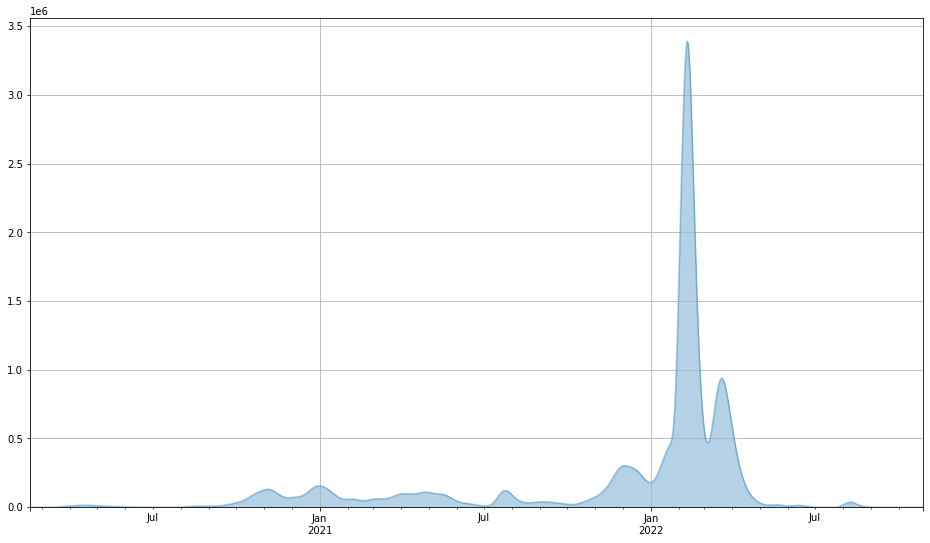

In [44]:
(
    df_dim
    [pr.pmeasure]
    [pr.dim]
    .rolling(14)
    .sum()
    .loc[start:floor]
    .plot(
        figsize=(16, 9),
        grid=True,
        kind='area',
        stacked=False,
        alpha=1/3,
    )
)

The top of this curve gives the maximum number of people that are infected at the same time.

In [45]:
print(
    'Maximum infected is {:1.0f}'
    .format(
        (
            df_dim
            [pr.pmeasure]
            [pr.dim]
            .rolling(14)
            .sum()
            .max()
        ),
    )
)

Maximum infected is 3389535


An approximation of the infection rate is the number of infected over the last week divided by the number of infectious in the two weeks before that, at least showing outbreak development.

<AxesSubplot:>

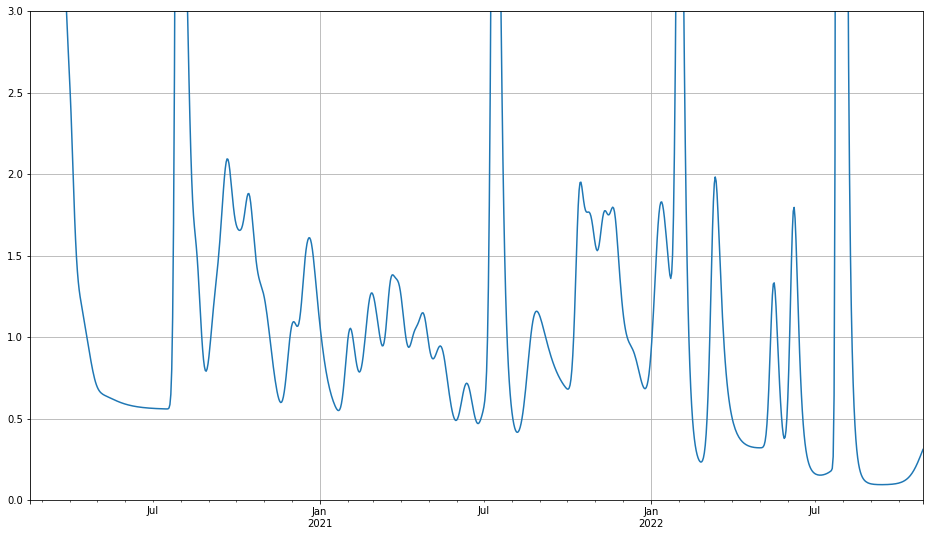

In [46]:
(
    (
        (
            df_dim
            [pr.pmeasure]
            [pr.dim]
            .rolling(7)
            .mean()
        )
        /
        (
            df_dim
            [pr.pmeasure]
            [pr.dim]
            .shift(7)
            .rolling(14)
            .mean()
        )
    )
    .loc[start:floor]
    .plot(
        figsize=(16, 9),
        grid=True,
        ylim=(0, 3),
    )
)

If we look at the difference between our actual (smoothed) value and our prediction, we can clearly see if the curve is breaking out after the floor. This can be the result of relaxing of measures and the beginning of a second wave, an increase in testing or other factors.

<AxesSubplot:>

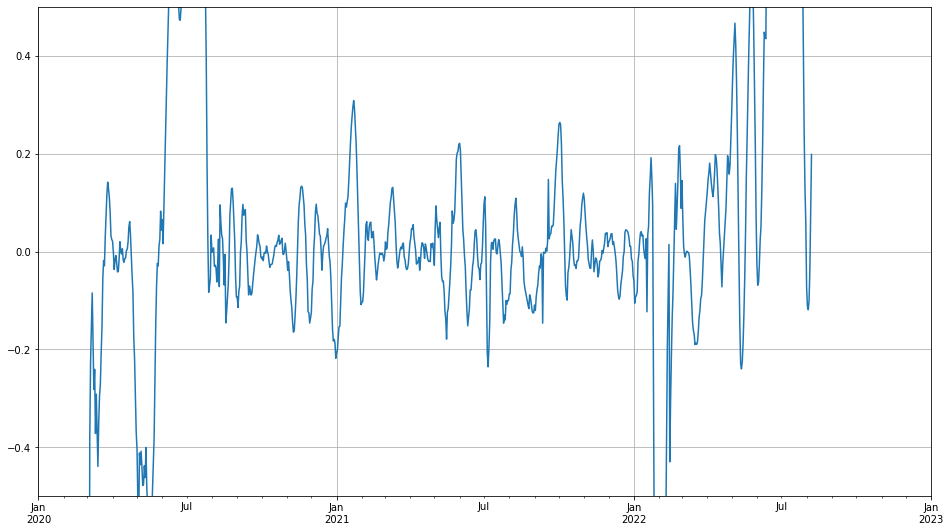

In [47]:
(
    (
#        1 -
        (
            (
                (
                    df_dim
                    [pr.smeasure]
                    [pr.dim]
#                    .cumsum()
                )
                -
                (
                    df_dim
                    [pr.pmeasure]
                    [pr.dim]
#                    .cumsum()
                )
            )
            /
            (
                df_dim
                [pr.smeasure]
                [pr.dim]
#                .cumsum()
            )
        )
#        ** 2
    )
    .rolling(1)
    .mean()
    .loc[pr.plotmin:pr.plotmax]
    .plot(
        figsize=(16, 9),
        grid=True,
        ylim=(-1/2, 1/2),
    )
)

Keep exploring! Stay home, wash your hands, keep your distance.